# AdaBoostClassifier

El modelo AdaBoost es un ensamble de tipo boosting que se basa en entrenar modelos utilizando instancias con pesos. Las instancias mal clasificadas por estimadores anteriores tendrán mayor peso, y los estimadores posteriores buscarán aprender más de dichas instancias, dando como resultado una (posible) mejora en su predicción.

Podemos utilizar como estimadores base los modelos desarrollados a lo largo del TP, y comparar los hiperparámetros de cada estimador base con los hiperparámetros conseguidos con los modelos individuales.

In [51]:
%load_ext autoreload
%autoreload 2
from preprocessing import *
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from scoring import *
pd.set_option('display.max_rows', 10)
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing Nº1

In [52]:
df_features, df_target = get_datasets(fecha_to_int=True)

df_features = barrios_a_comunas(df_features)
viento_trigonometrico(df_features)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=0)

# Guardo la pipe con un nombre especial para poder
# usarla al final del notebook
pipe_ = simple_imputer()
pipe_ = standarizer(pipe_)

pipe_.fit(X_train)
X_train = pipe_.transform(X_train)
X_test = pipe_.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

### Estimador base: DecisionTreeClassifier

In [53]:
parameters = {
    "n_estimators": np.arange(1,10,2),
    "base_estimator__criterion": ["gini", "entropy"],
    "base_estimator__max_depth": [3, 5, 15, 25],
    "base_estimator__min_samples_leaf": [100, 500, 1000]
}

base_estimator = DecisionTreeClassifier(random_state=0)

grid = GridSearchCV(AdaBoostClassifier(base_estimator=base_estimator, random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    scoring = SCORINGS,
                    refit=METRIC,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.8644899020692703

In [54]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.86947,0.843463,0.687325,0.551814,0.61216


In [55]:
grid_history_table(grid)

,param_base_estimator__criterion,param_base_estimator__max_depth,param_base_estimator__min_samples_leaf,param_n_estimators,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,gini,15,1000,9,0.864490,0.838918,0.677346,0.535755,0.598285
1,entropy,25,1000,9,0.864380,0.838407,0.675601,0.535486,0.597379
2,entropy,15,1000,9,0.864071,0.839354,0.680237,0.533271,0.597814
3,entropy,15,1000,7,0.863983,0.840091,0.681952,0.535890,0.600108
4,gini,15,500,9,0.863863,0.839084,0.671841,0.549923,0.604786
...,...,...,...,...,...,...,...,...,...
115,entropy,3,500,1,0.800198,0.828846,0.730322,0.373531,0.494225
116,entropy,3,100,1,0.800198,0.828846,0.730322,0.373531,0.494225
117,gini,3,1000,1,0.787738,0.827854,0.736649,0.362186,0.484594
118,gini,3,100,1,0.787687,0.827854,0.736649,0.362186,0.484594


Los resultados fueron bastante similares a los obtenidos con un único árbol de decisión. El aumento en complejidad que produce el ensamble, hace que el modelo sea peor al modelo individual. Podemos intentar mejorar el score aumentando el número de estimadores, y analizar en qué punto se produce overfitting

In [56]:
parameters = {
    "n_estimators": np.arange(1,50,1),
}

base_estimator = DecisionTreeClassifier(max_depth=15, min_samples_leaf=1000, random_state=0)
grid = GridSearchCV(AdaBoostClassifier(base_estimator=base_estimator, random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    scoring = SCORINGS,
                    refit=METRIC,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.8691931132511457

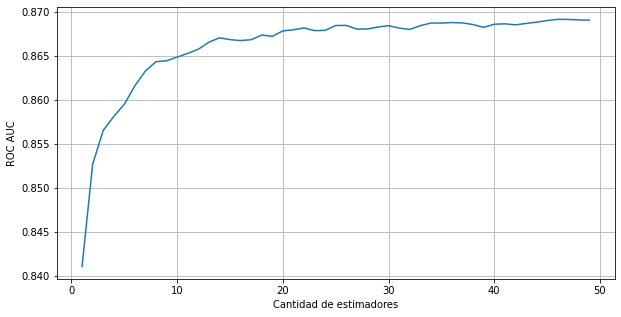

In [57]:
n_estimators = grid.cv_results_["param_n_estimators"].data
results = grid.cv_results_["mean_test_roc_auc"]
plt.figure(figsize=(10,5))
plt.xlabel("Cantidad de estimadores")
plt.ylabel("ROC AUC")
plt.grid(True)
plt.plot(n_estimators, results)

En el gráfico observamos que, al aumentar el número de estimadores, el score aumenta de forma prácticamente asintótica a un valor de 0.87. Es interesante notar que no se produjo overfitting, a pesar de haber entrenado modelos con hasta 50 estimadores.

### Estimador base: RandomForestClassifier

Probamos también con estimadores base mucho más complejos, como es el caso de un random forest. Algo a tener en cuenta es que, para poder afirmar que el modelo resultante es efectivamente mejor, se debería observar una mejora sustancial en los scores. En caso contrario, estaríamos frente a un modelo altamente complejo (ensamble de ensambles), con menores posibilidades de generalizar mejor frente a instancias nuevas.

### Pocos árboles

Empezamos con una cantidad modesta de árboles. Posiblemente, los random forest resultantes tengan alta varianza, y al entrenarlos con boosting, tal vez produzca modelos con mejor capacidad para clasificar instancias complejas

In [58]:
parameters = {
    "n_estimators": np.arange(1, 30, 2),
}

base_estimator = RandomForestClassifier(criterion="entropy",
                                        n_estimators=5,
                                        max_depth=35,
                                        n_jobs=-1,
                                        random_state=0)

grid = GridSearchCV(AdaBoostClassifier(base_estimator=base_estimator, random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    scoring = SCORINGS,
                    refit=METRIC,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.8578661729736418

In [59]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.861866,0.846311,0.733037,0.493079,0.589577


In [60]:
grid_history_table(grid)

,param_n_estimators,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,29,0.857866,0.844120,0.731399,0.481030,0.579968
1,5,0.856845,0.844676,0.750158,0.459209,0.569683
2,7,0.856482,0.845503,0.746343,0.469549,0.576397
3,27,0.856375,0.844150,0.729130,0.483717,0.581560
4,25,0.855868,0.842165,0.722596,0.479353,0.576242
...,...,...,...,...,...,...
10,13,0.854047,0.843759,0.727048,0.483919,0.581013
11,17,0.852531,0.841729,0.715044,0.487812,0.579824
12,21,0.852076,0.841459,0.711958,0.490835,0.580833
13,3,0.850431,0.841218,0.731927,0.458874,0.564090


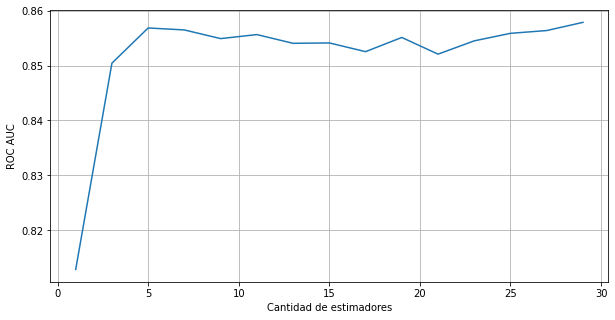

In [61]:
n_estimators = grid.cv_results_["param_n_estimators"].data
results = grid.cv_results_["mean_test_roc_auc"]
plt.figure(figsize=(10,5))
plt.xlabel("Cantidad de estimadores")
plt.ylabel("ROC AUC")
plt.grid(True)
plt.plot(n_estimators, results)

Los modelos resultaron bastante malos. Posiblemente se deba a que, internamente, el random forest toma $\sqrt{n}$ features para cada árbol (siendo $n$ el número total de features). Esto hace que exista una probabilidad muy alta de que ningún árbol obtenga las features que son predictores fuertes (***humedad_tarde***, por ejemplo).

Con esto en mente, aumentamos la cantidad de estimadores

### Muchos árboles

In [62]:
parameters = {
    "n_estimators": [1, 3, 5, 10, 12, 15],
}

base_estimator = RandomForestClassifier(criterion="entropy",
                                        n_estimators=200,
                                        max_depth=35,
                                        n_jobs=-1,
                                        random_state=0)

# Lo guardamos con otro nombre porque fue el modelo final
grid_ = GridSearchCV(AdaBoostClassifier(base_estimator=base_estimator, random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    scoring = SCORINGS,
                    refit=METRIC,
                    n_jobs = -1)

grid_.fit(X_train, Y_train)
grid_.best_score_

0.8876549664389612

In [63]:
grid_history_table(grid_)

,param_n_estimators,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,15,0.887655,0.854538,0.775829,0.493184,0.602891
1,3,0.887632,0.854282,0.775444,0.492043,0.601904
2,12,0.887571,0.854342,0.776052,0.491774,0.601872
3,10,0.887484,0.854523,0.776516,0.492379,0.602471
4,5,0.887460,0.854312,0.774979,0.492714,0.602286
5,1,0.885699,0.854207,0.767371,0.500638,0.605927


In [64]:
metrics_table(Y_test, grid_.best_estimator_.predict(X_test), grid_.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.894141,0.860744,0.807466,0.496321,0.614767


El score mejoró un poco en el set de test, en comparación al random forest individual.

## Preprocessing Nº 2

Como el siguiente modelo a probar es GaussianNB, utilizamos el preprocessing que dio el mejor resultado para un estimador individual

In [65]:
df_features, df_target = get_datasets(fecha_to_int=True)

viento_trigonometrico(df_features)
drop_categoricas(df_features)

df_features = df_features[['dia',
                           'horas_de_sol',
                           'humedad_tarde',
                           'nubosidad_tarde',
                           'presion_atmosferica_tarde',
                           'rafaga_viento_max_velocidad',
                           'temp_min',
                           'cos_viento_tarde',
                           'sin_viento_tarde',
                           'cos_viento_temprano',
                           'sin_viento_temprano',
                           'cos_rafaga_viento_max_direccion',
                           'sin_rafaga_viento_max_direccion']]

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size = 0.35, random_state = 0)

pipe = iterative_imputer()
pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

### Estimador base: GaussianNB

Utilizamos el preprocessing que dio el mejor resultado para un estimador individual

In [ ]:
parameters = {
    "n_estimators": np.arange(1, 50, 1),
}

base_estimator = GaussianNB(var_smoothing = 1e-8)

grid = GridSearchCV(AdaBoostClassifier(base_estimator=base_estimator, random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    scoring = SCORINGS,
                    refit=METRIC,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

In [ ]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

In [ ]:
grid_history_table(grid)

Vemos que el score aumentó ligeramente al utilizar 3 estimadores en lugar de 1, aunque no parece ser una mejora significativa

In [ ]:
n_estimators = grid.cv_results_["param_n_estimators"].data
results = grid.cv_results_["mean_test_roc_auc"]
plt.figure(figsize=(10,5))
plt.xlabel("Cantidad de estimadores")
plt.ylabel("ROC AUC")
plt.grid(True)
plt.plot(n_estimators, results)

Este gráfico es realmente interesante. Por un lado, podemos ver que el score máximo se dio con 3 estimadores (como se observó en la tabla). Pero también vemos un patrón de dientes de sierra en el que, por algún motivo, los modelos con una cantidad par de estimadores da mucho peor que aquellos con una cantidad impar. No fue posible determinar el motivo con exactitud, quizá se deba al algoritmo interno de AdaBoost para asignar los pesos en cada iteración.

De los tres modelos entrenados, el que dio mejores resultados fue el que utilizó random forest. No mejoró mucho respecto del estimador individual (un solo random forest), pero fue mejor que utilizar DecisionTreeClassifier y GaussianNB.

## Predicción de nuevos datos

In [ ]:
df_extra = pd.read_csv("datasets/df_extra.csv", low_memory = False, index_col = "id")

common(df_extra)
df_extra = barrios_a_comunas(df_extra)
viento_trigonometrico(df_extra)

model = grid_.best_estimator_

pipe_.steps.append(("ada", model))

df_extra_predict = pd.DataFrame({"id": df_extra.index, "llovieron_hamburguesas_al_dia_siguiente": pipe_.predict(df_extra)})
df_extra_predict.set_index("id", inplace = True)
df_extra_predict.replace({"llovieron_hamburguesas_al_dia_siguiente": {0.0: "no", 1.0: "si"}}, inplace = True)
df_extra_predict.to_csv("predicciones/AdaBoostClassifier.csv")

## Predicción en Holdout

In [ ]:
df_features_holdout = pd.read_csv("datasets/df_features_holdout.csv", low_memory = False, index_col = "id")
df_target_holdout = pd.read_csv("datasets/df_target_holdout.csv", low_memory = False, index_col = "id")

common(df_features_holdout, df_target_holdout)
df_features_holdout = barrios_a_comunas(df_features_holdout)
viento_trigonometrico(df_features_holdout)

In [ ]:
metrics_table(df_target_holdout, pipe_.predict(df_features_holdout), pipe_.predict_proba(df_features_holdout)[:,1])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

ConfusionMatrixDisplay.from_predictions(df_target_holdout, pipe_.predict(df_features_holdout), ax=axs[0])
RocCurveDisplay.from_predictions(df_target_holdout, pipe_.predict_proba(df_features_holdout)[:,1], ax=axs[1], name="AdaBoost")
plt.show()

Tal y como ocurrió con el resto de modelos, las métricas ROC-AUC y Accuracy no difirieron mucho de los resultados en el set de test, mientras que sí lo hicieron el resto de las métricas.

En el random forest se había observado un leve incremento en Precision, que no se ve reflejado en este ensamble de random forest. No parece muy relevante, y probablemente se deba a una casualidad al separar los datos en *train* y *test*.